# CSC 730 Assignment 7 - Isolation Forest
## Mangesh Sakordekar

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn import datasets, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import random
import math
from sklearn.metrics import confusion_matrix
import sys
from sklearn.ensemble import IsolationForest as iforest

### Loading the Data

In [2]:
data = np.load('../Datasets/X_and_y.npz')

In [3]:
y = data['y']
X = data['X'].reshape((len(y), 28*28))

In [4]:
X_norm = X/255.0
X_scaled = StandardScaler().fit_transform(X_norm) 

In [5]:
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_scaled)

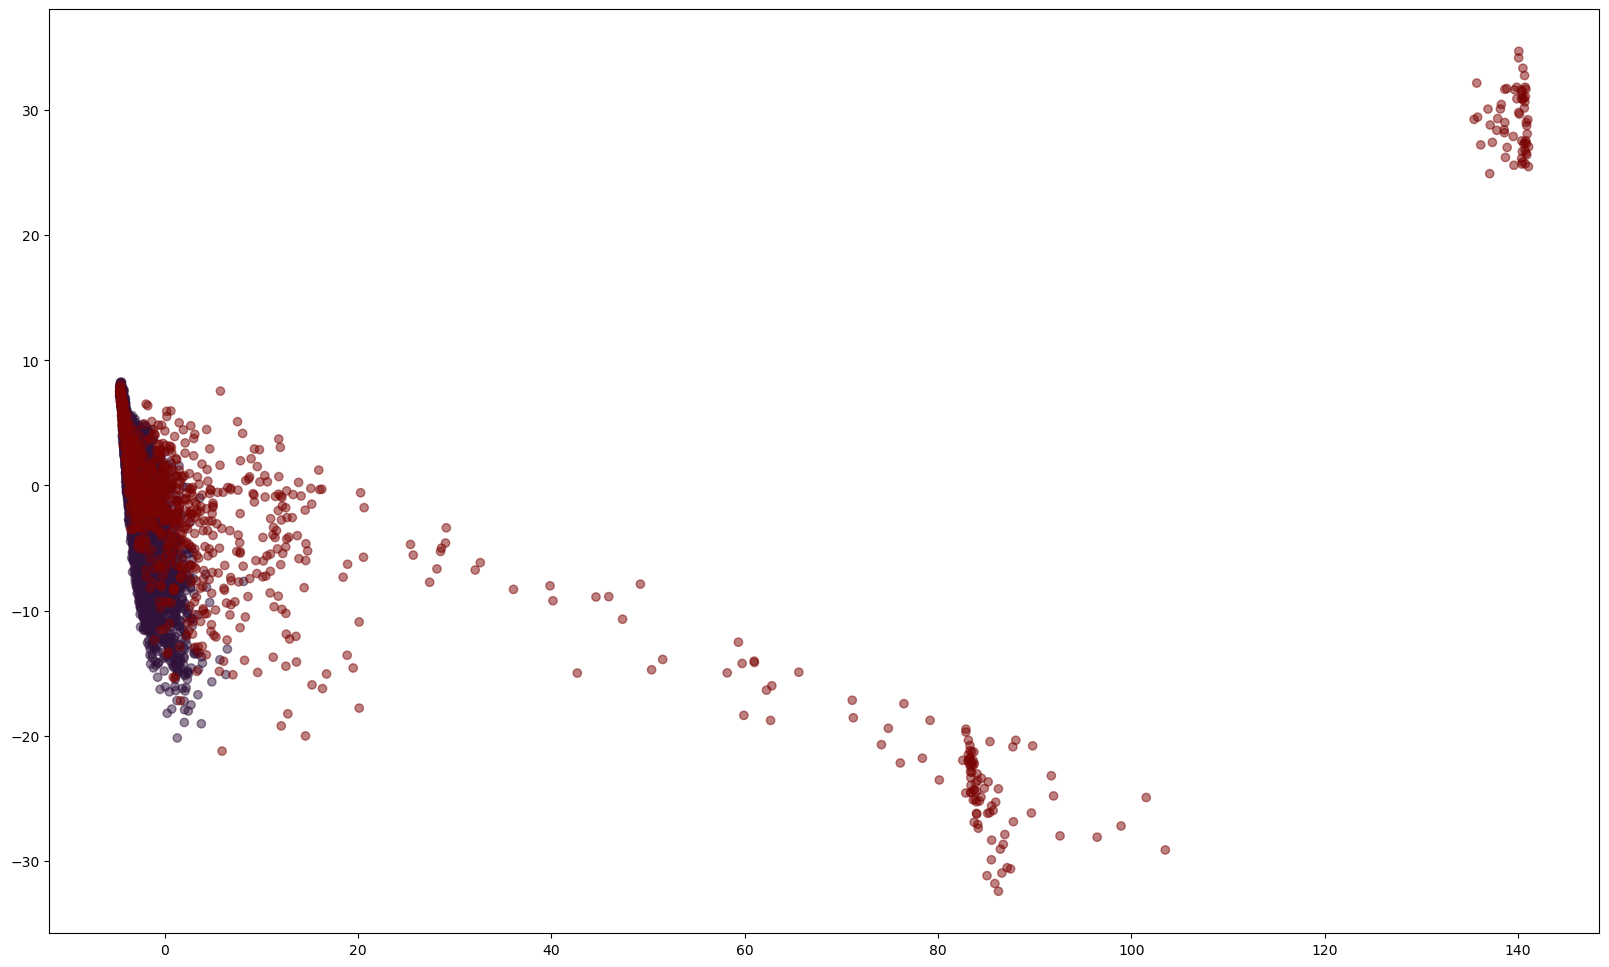

In [6]:
plt.figure(figsize=(20,12))
plt.scatter(X_pca[:, 0], X_pca[:,1], c=y, cmap='turbo', alpha=0.5)

In [7]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

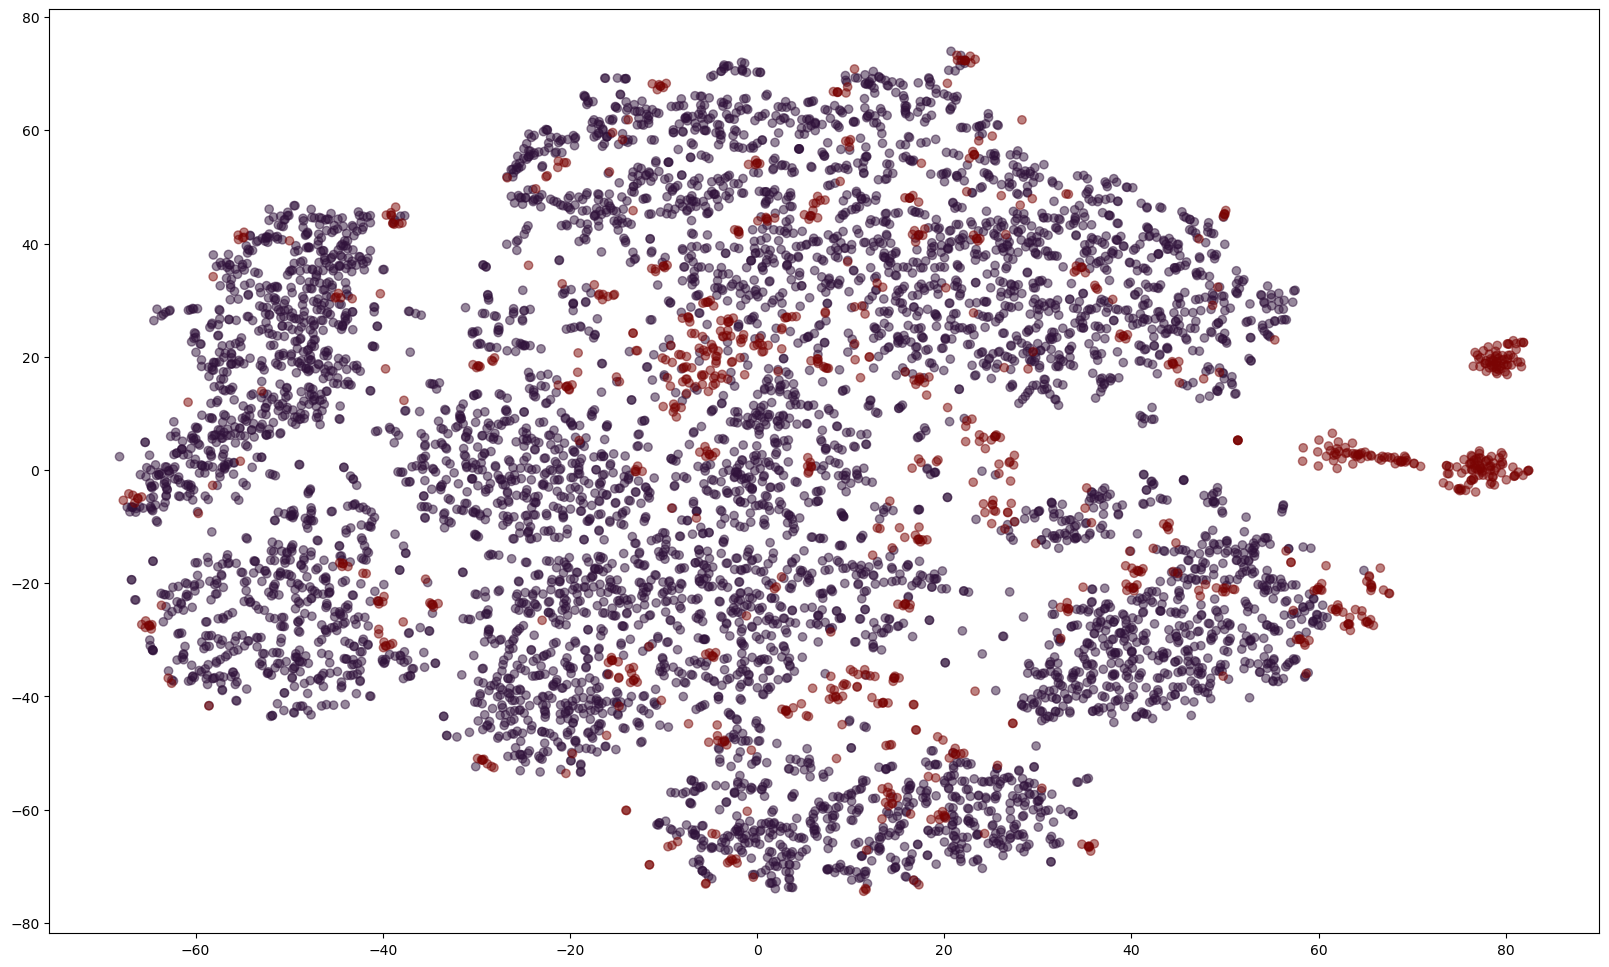

In [8]:
plt.figure(figsize=(20,12))
plt.scatter(X_tsne[:, 0], X_tsne[:,1], c=y, cmap='turbo', alpha=0.5)

### Class Definitions

#### Node Class
Forms the nodes of isolation trees. Can be initialised as internal or external nodes

In [9]:
class Node:

    def __init__(self, size = 0, left = None, right = None, 
                 attr = None, val = None, is_external = False):
        self.size = size
        self.left = left
        self.right = right
        self.split_attr = attr
        self.split_val = val
        self.is_external = is_external
        

    @classmethod
    def internal(node, left, right, attr, val):
        return node(None, left, right, attr, val, False)

    @classmethod
    def external(node, size):
        return node(size, None, None, None, None, True)

#### IsolationForest Class
Generates and stores isolation trees using the parameters provided.

In [10]:
class IsolationForest:

    def __init__(self, sampling_size = 256, tree_count=200):
        self._forest = None
        self._sampling_size = sampling_size
        self._C_factor = self._c_factor(sampling_size)
        self._tree_count = tree_count
        self._height_limit = math.ceil(math.log2(sampling_size))
    
    def _isolation_tree(self, data,counter=0):
        if (counter == self._height_limit) or len(data)<=1:
            return Node.external(len(data))
        
        feature_index = random.randint(0, data.shape[1]-1)
        min_val = np.min(data[:,feature_index]) 
        max_val = np.max(data[:,feature_index]) 
        
        filter_value = random.uniform(min_val, max_val)
    
        left_indexes = np.where(data[:,feature_index] < filter_value)[0]
        right_indexes = np.where(data[:,feature_index] >= filter_value)[0]

        return Node.internal(self._isolation_tree(data[left_indexes,:], counter + 1),
                             self._isolation_tree(data[right_indexes,:], counter + 1),
                             feature_index, filter_value)


    def _isolation_forest(self, data):
        forest = []
        for i in range(0, self._tree_count):
            forest.append(self._isolation_tree(data, 0))
        return forest

    
    def fit(self, data):
        self._forest = self._isolation_forest(data)

    
    def _c_factor(self, n):
        if n > 2:
            return 2.0*(np.log(n-1)+0.5772156649) - (2.0*(n-1.)/(n*1.0))
        if n == 2:
            return 1
        return 0

    
    def _path_length(self, x, tree, curr_length):
        if tree.is_external :
            return curr_length + self._c_factor(tree.size)
        if x[tree.split_attr]  < tree.split_val:
            return self._path_length(x, tree.left, curr_length+1)
        return self._path_length(x, tree.right, curr_length+1)


    def _get_paths(self, data_point):
        paths = []
        for tree in self._forest:
            paths.append(self._path_length(data_point, tree, 0))
        return paths

    
    def _anomaly_score(self, data_point):
        E = np.mean(self._get_paths(data_point))
        return 2**-(E/self._C_factor)


    def get_scores(self, data_set):
        scores = []
        for i in range(0, data_set.shape[0]):
            scores.append(self._anomaly_score(data_set[i,:]))
        return np.asarray(scores)
        

### Helper Functions

In [11]:
def plot_graph(i_tree, X, y, title):
    xx, yy = np.meshgrid(np.linspace(np.min(X[:,0])-10, np.max(X[:,0])+10, 100), np.linspace(np.min(X[:,1])-10, np.max(X[:,1])+10, 100), indexing="xy")
    xy = np.dstack((xx, yy))
    zz = np.ndarray((100 , 100))
    for i in range(0, 100):
        for j in range(0, 100):
            zz[i][j] = i_tree.get_scores(xy[i][j].reshape(1,-1))
    
    plt.figure(figsize=(20,15))
    plt.contourf(xx, yy, zz, levels=10, cmap='RdYlGn_r')
    plt.colorbar()
    plt.scatter(X[:, 0], X[:,1], c=y, cmap='turbo', alpha=0.3)
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.title(title)
    plt.show()

In [12]:
def get_metrics(y_true, y_pred):
    
    # generate consusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    true_positive_rate = tp/(tp+fn)
    false_positive_rate = fp/(fp+tn)
    precision = tp/(tp+fp)
    return np.array([[true_positive_rate, false_positive_rate, precision]])



def generate_metrics_data(scores, y):
    
    rank = np.argsort(scores)[::-1]

    scores_ranked = scores[rank]
    y_ranked = y[rank]
    y_pred = np.zeros(y.shape)
    metrics = np.empty((0,3)) #get_metrics(y_ranked, y_pred) 
    for i in range(0, len(y)):
        y_pred[i] = 1
        metrics = np.append( metrics, get_metrics(y_ranked, y_pred), axis=0)
        
    true_positive_rates = metrics[:,0]
    false_positive_rates = metrics[:,1]
    precisions = metrics[:,2]
    
    return true_positive_rates, false_positive_rates, precisions

In [13]:
def plot_roc(true_positive_rates, false_positive_rates, legend, clr):
    plt.figure(figsize=(20, 12))
    
    for i in range(0,len(true_positive_rates)):
        plt.plot(false_positive_rates[i], true_positive_rates[i], color=clr[i], lw=2, label=legend[i] )
        
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(title='ROC Curves')
    plt.show()
    
def plot_pr(true_positive_rates,  precisions, legend, clr):
    plt.figure(figsize=(20, 12))
    
    for i in range(0,len(true_positive_rates)):
        plt.plot(true_positive_rates[i], precisions[i], color=clr[i], lw=2, label=legend[i])
        
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(title='PR Curves')
    plt.title('Precision-Recall Curve')
    plt.show()

### Using PCA

In [14]:
i_tree_pca = IsolationForest()
i_tree_pca.fit( X_pca)
scores_pca = i_tree_pca.get_scores(X_pca)

C:\Users\mange\AppData\Local\Temp\ipykernel_17740\3892528628.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zz[i][j] = i_tree.get_scores(xy[i][j].reshape(1,-1))


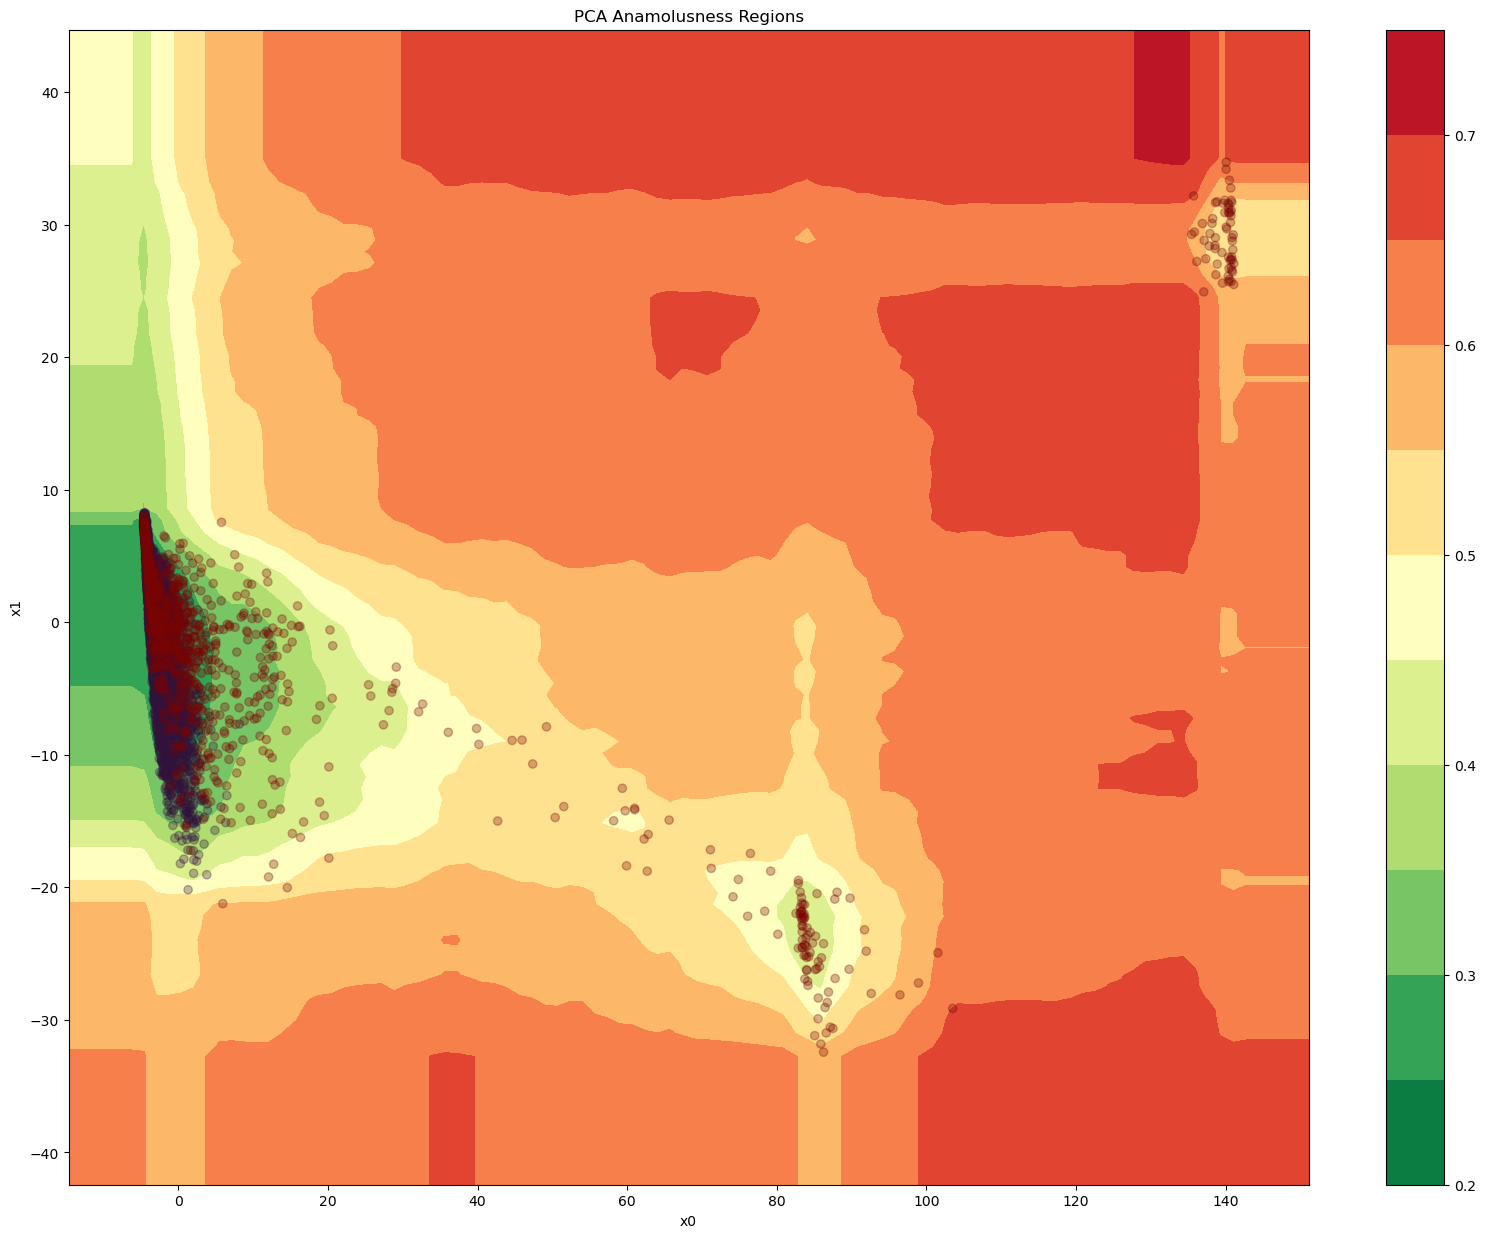

In [15]:
plot_graph(i_tree_pca, X_pca, y, 'PCA Anamolusness Regions')

### Using tSNE

In [16]:
i_tree_tsne = IsolationForest()
i_tree_tsne.fit( X_tsne)
scores_tsne = i_tree_tsne.get_scores(X_tsne)

C:\Users\mange\AppData\Local\Temp\ipykernel_17740\3892528628.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zz[i][j] = i_tree.get_scores(xy[i][j].reshape(1,-1))


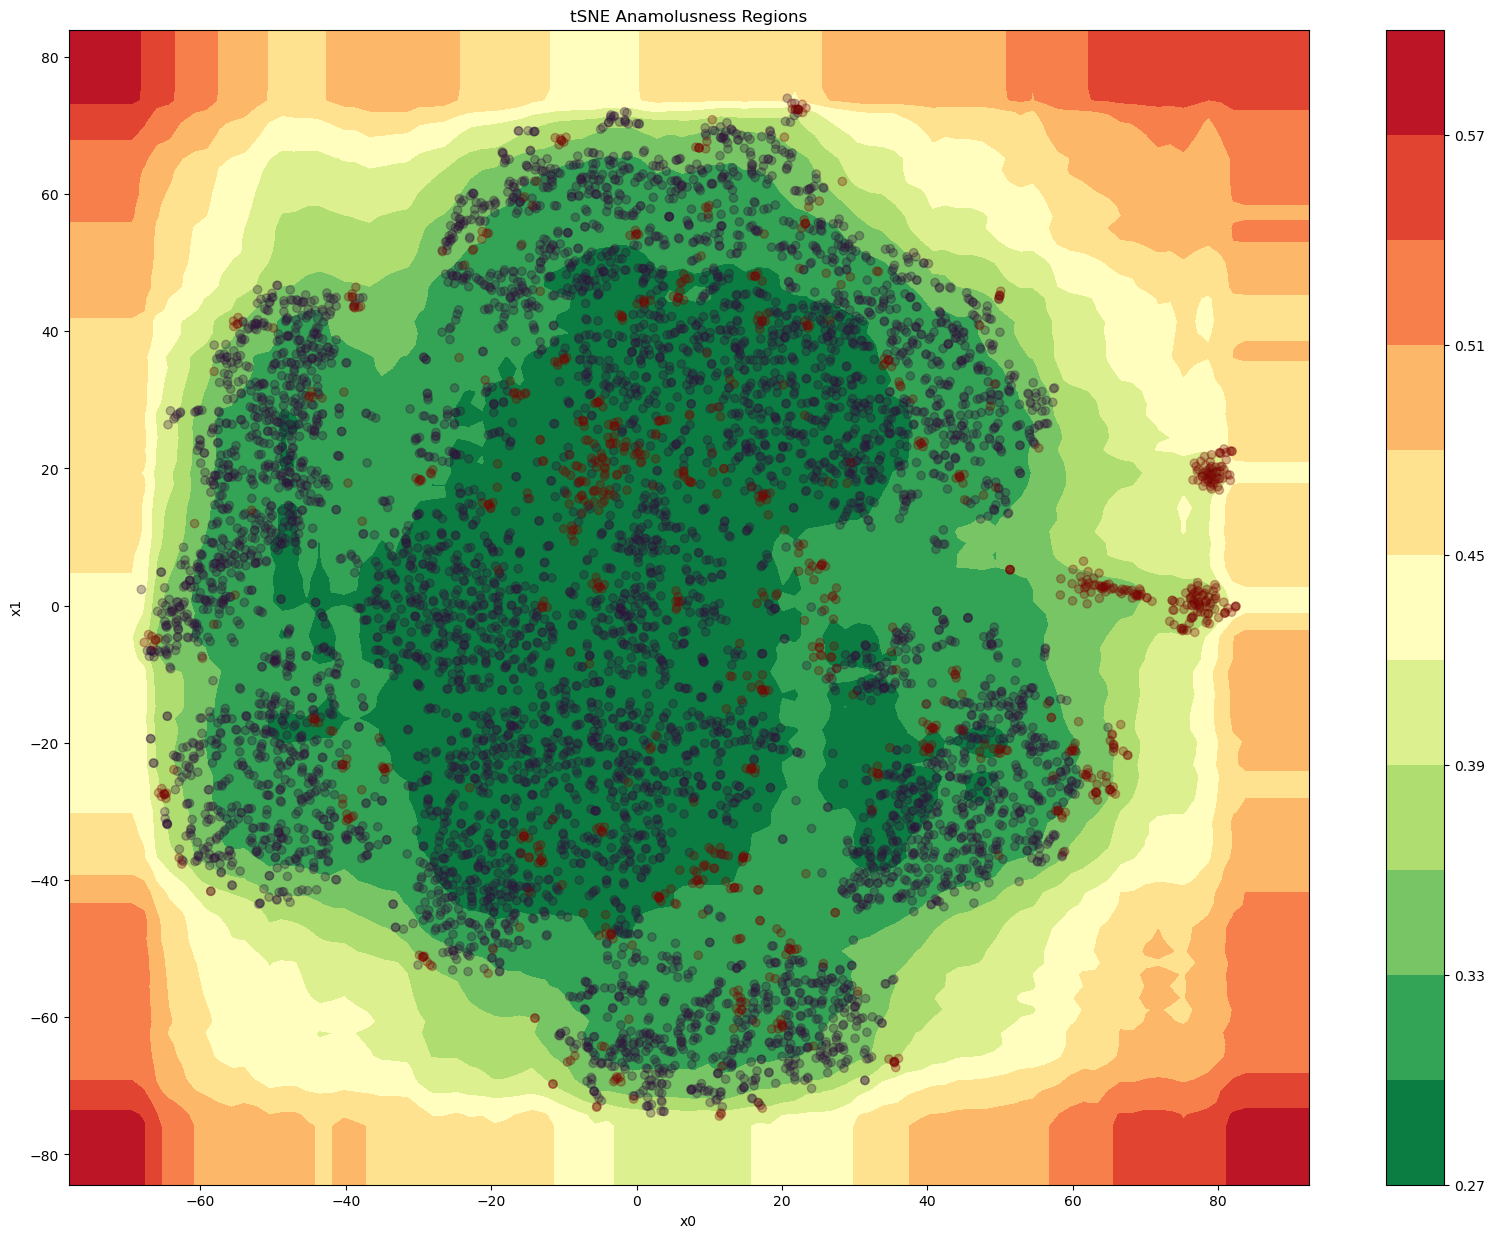

In [17]:
plot_graph(i_tree_tsne, X_tsne, y, 'tSNE Anamolusness Regions')

### Using Uncompressed Data

In [18]:
i_tree_786 = IsolationForest()
i_tree_786.fit( X_scaled)
scores_786 = i_tree_786.get_scores(X_scaled)

### Using sklearn

In [19]:
i_tree_skl = iforest(random_state=0).fit(X_scaled)
scores_skl = -i_tree_skl.score_samples(X_scaled)

i_tree_skl_pca = iforest(random_state=0).fit(X_pca)
scores_skl_pca = -i_tree_skl_pca.score_samples(X_pca)

i_tree_skl_tsne = iforest(random_state=0).fit(X_tsne)
scores_skl_tsne = -i_tree_skl_tsne.score_samples(X_tsne)

### Plot Curves

In [20]:
tpr_pca, fpr_pca, pre_pca = generate_metrics_data(scores_pca, y)
tpr_tsne, fpr_tsne, pre_tsne = generate_metrics_data(scores_tsne, y)
tpr, fpr, pre = generate_metrics_data(scores_786, y)
tpr_skl, fpr_skl, pre_skl = generate_metrics_data(scores_skl, y)
tpr_skl_pca, fpr_skl_pca, pre_skl_pca = generate_metrics_data(scores_skl_pca, y)
tpr_skl_tsne, fpr_skl_tsne, pre_skl_tsne = generate_metrics_data(scores_skl_tsne, y)

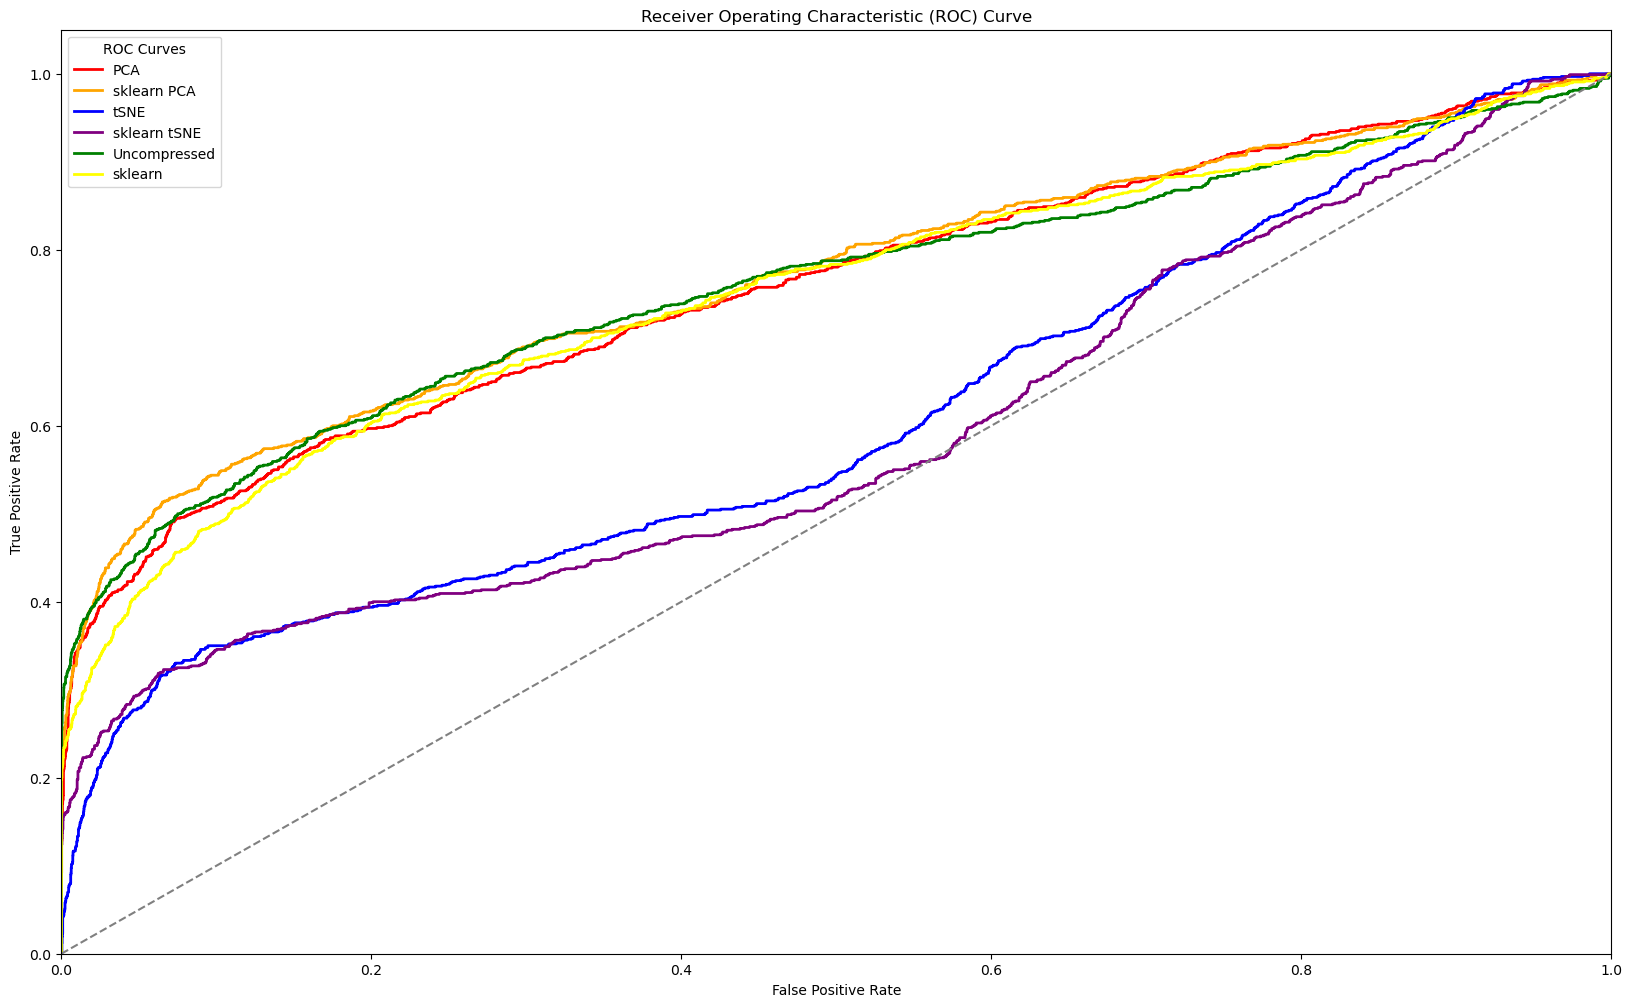

In [21]:
plot_roc([tpr_pca, tpr_skl_pca, tpr_tsne, tpr_skl_tsne, tpr, tpr_skl], [fpr_pca, fpr_skl_pca, fpr_tsne, fpr_skl_tsne, fpr, fpr_skl], 
         ['PCA', 'sklearn PCA', 'tSNE', 'sklearn tSNE', 'Uncompressed', 'sklearn'], ['red','orange', 'blue','purple','green', 'yellow'])

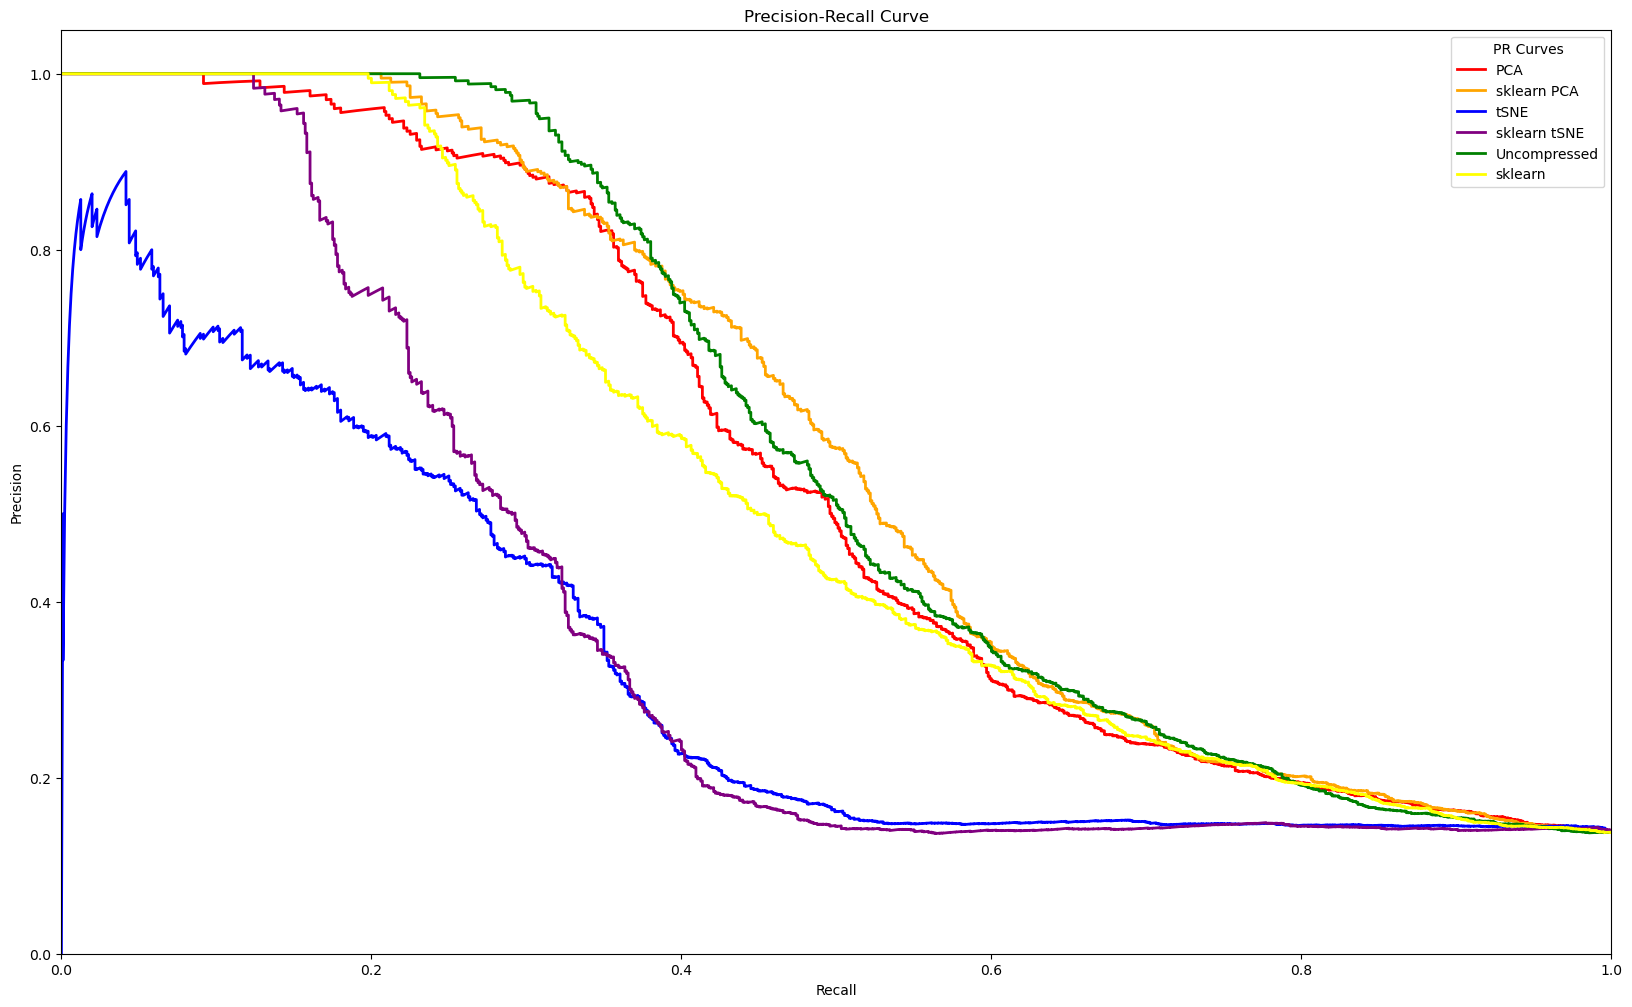

In [22]:
plot_pr([tpr_pca, tpr_skl_pca, tpr_tsne, tpr_skl_tsne, tpr, tpr_skl], [pre_pca, pre_skl_pca, pre_tsne, pre_skl_tsne, pre, pre_skl], 
         ['PCA', 'sklearn PCA', 'tSNE', 'sklearn tSNE', 'Uncompressed', 'sklearn'], ['red','orange', 'blue','purple','green', 'yellow'])